# Project: Classification and Segmentation of Breast Cancer Ultrasound Images

In [1]:
# !pip install -U segmentation-models-pytorch

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
from torchvision import transforms
import numpy as np
import cv2
from tqdm import tqdm
from tqdm.notebook import tqdm as blue_tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import sys
# path = "/content/drive/MyDrive"
# # path = "/content/drive/MyDrive"
# sys.path.append(path)
# %cd {path}


# Access data

In [5]:
data_dir = "Dataset_BUSI_with_GT/"
model_dir = "seg_class/vgg19_attend_higherdecay"
!mkdir $model_dir

In [6]:
classes = ['normal', 'benign', 'malignant']

In [7]:
# lists of lists for mask files
mask_1 = sorted([sorted([os.path.join(data_dir, name, f) for f in os.listdir(os.path.join(data_dir, name)) if f.endswith("mask.png")]) for name in classes])
mask_2 = sorted([sorted([os.path.join(data_dir, name, f) for f in os.listdir(os.path.join(data_dir, name)) if f.endswith("mask_1.png")]) for name in classes])


In [8]:
# num of images for each class
print([len(i) for i in mask_1])

[437, 210, 133]


In [9]:
# all mask file in one list
all_mask_1 = [item for sublist in mask_1 for item in sublist]
len(all_mask_1)

780

In [10]:
all_mask_2 = [item for sublist in mask_2 for item in sublist]
# all_mask_2

In [11]:
# lists of lists for image files
image_files = sorted([sorted([os.path.join(data_dir, name, f) for f in os.listdir(os.path.join(data_dir, name)) if f.endswith(").png")]) for name in classes])

In [12]:
all_image_files = [item for sublist in image_files for item in sublist]
len(all_image_files)

780

## Show images from directory

Class: normal


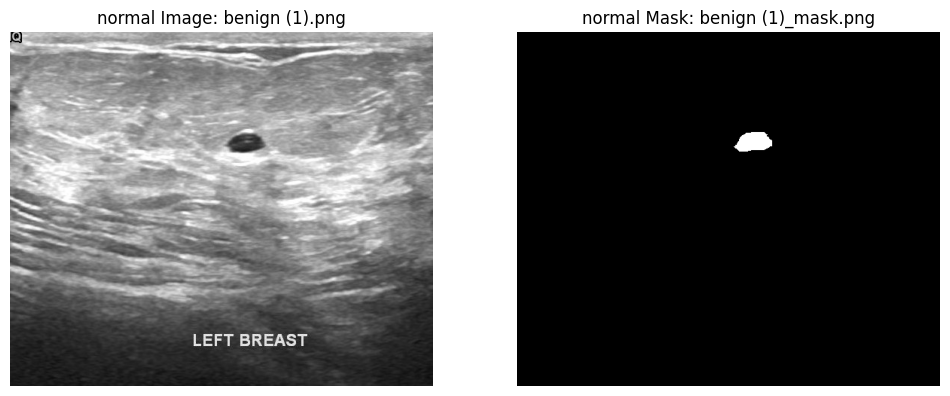

Class: benign


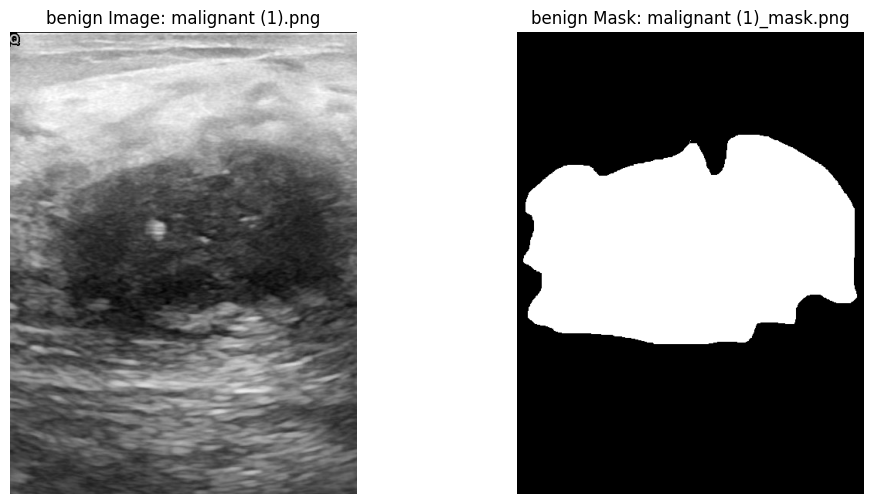

Class: malignant


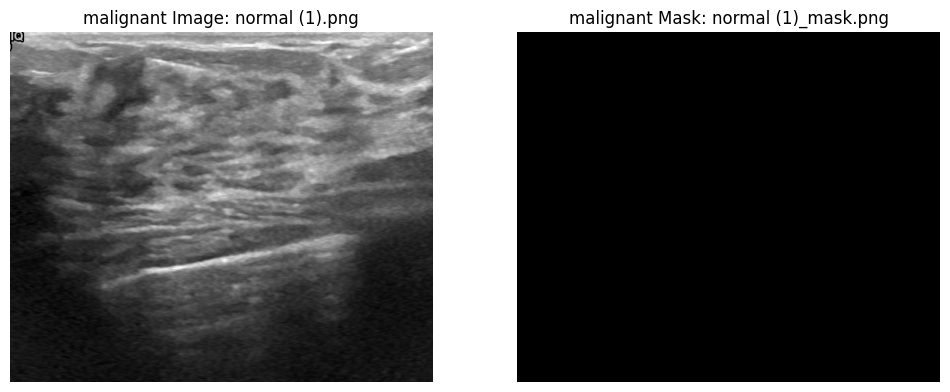

In [13]:
def show_images_from_directory(image_paths, mask_paths, classes, n = 1):
    # Iterate through each class
    for class_index, class_name in enumerate(classes):
        print(f"Class: {class_name}")

        # Get the first n image paths for the current class
        class_image_paths = image_paths[class_index][:n]
        class_mask_paths = mask_paths[class_index][:n]

        # Iterate through the selected images and masks
        for image_path, mask_path in zip(class_image_paths, class_mask_paths):
            # Load the image and mask
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Create a subplot with 1 row and 2 columns
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

            # Display the image
            ax1.imshow(image)
            ax1.axis('off')
            ax1.set_title(f'{class_name} Image: {image_path.split("/")[-1]}')

            # Display the corresponding mask
            ax2.imshow(mask, cmap='gray')
            ax2.axis('off')
            ax2.set_title(f'{class_name} Mask: {mask_path.split("/")[-1]}')

            # Show the plots
            plt.show()

show_images_from_directory(image_files, mask_1, classes, 1)


# Combine mask images

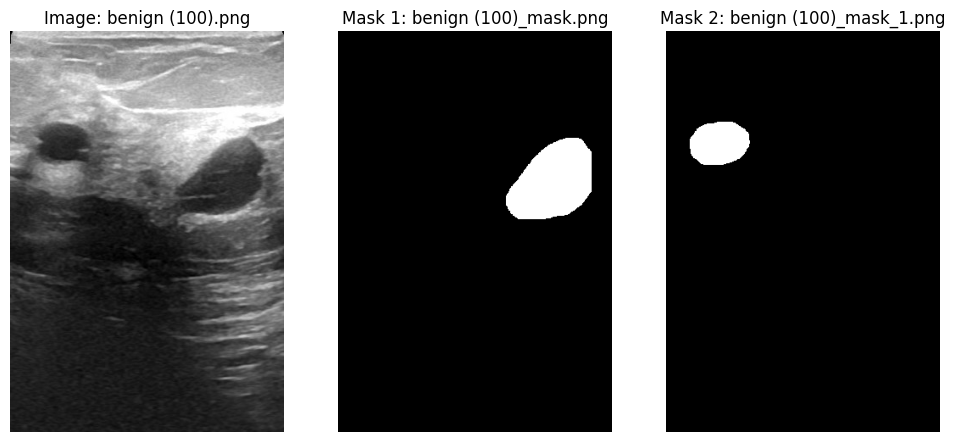

In [14]:
# example: how to combine masks for one image
example = 'Dataset_BUSI_with_GT/benign/benign (100).png'
mask1 = 'Dataset_BUSI_with_GT/benign/benign (100)_mask.png'
mask2 = 'Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png'
# Load the image and mask
image100 = Image.open(example)
mask100_1 = Image.open(mask1)
mask100_2 = Image.open(mask2)

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))

# Display the image
ax1.imshow(image100)
ax1.axis('off')
ax1.set_title(f'Image: {example.split("/")[-1]}')

# Display the corresponding mask
ax2.imshow(mask100_1, cmap='gray')
ax2.axis('off')
ax2.set_title(f'Mask 1: {mask1.split("/")[-1]}')

# Display the corresponding mask
ax3.imshow(mask100_2, cmap='gray')
ax3.axis('off')
ax3.set_title(f'Mask 2: {mask2.split("/")[-1]}')


# Show the plots
plt.show()




[0 1]


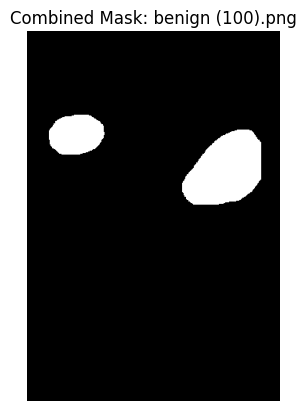

In [15]:
# combine mask

a = Image.open(mask1).convert('L')
b = Image.open(mask2).convert('L')

a = (np.array(a) > 0).astype(np.uint8)
b = (np.array(b) > 0).astype(np.uint8)


combined_mask = np.logical_or(a, b).astype(np.uint8)
print(np.unique(combined_mask))
# combined_mask = np.logical_not(combined_mask).astype(np.uint8)
# print(combined_mask)
combined_mask_img = Image.fromarray(combined_mask * 255)  # Multiply by 255 for proper display
# print(np.unique(combined_mask * 255))

plt.imshow(combined_mask_img, cmap='gray')
plt.axis('off')
plt.title(f'Combined Mask: {example.split("/")[-1]}')
plt.show()



## Split Data into train, val, test

In [16]:
from sklearn.model_selection import train_test_split

# Assuming your data is organized in three folders: folder1, folder2, folder3
classes = ['normal', 'benign', 'malignant']
X_train = []
X_validation = []
X_test = []
mask_paths= {}
label_paths = {}
for class_name in classes:
    image_paths = []
    class_folder = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_folder) if not f.endswith('mask.png') and not f.endswith('mask_1.png')]
    if class_name == 'normal':
        class_label = 0
    elif class_name == 'benign':
        class_label = 1
    else:
        class_label = 2
    for image_file in image_files:
        image_path = os.path.join(class_folder, image_file)
        mask_file_1 = image_file.replace('.png', '_mask.png')
        mask_file_2 = image_file.replace('.png', '_mask_1.png')
        mask_path_1 = os.path.join(class_folder, mask_file_1)
        mask_path_2 = os.path.join(class_folder, mask_file_2)
        label_paths[image_path] = class_label
            
        mask_paths_for_image = []
        if os.path.exists(mask_path_1):
            mask_paths_for_image.append(mask_path_1)
            # label_paths[mask_path_1] = class_label
        if os.path.exists(mask_path_2):
            mask_paths_for_image.append(mask_path_2)
            # label_paths[mask_path_2] = class_label
            
        if mask_paths_for_image:
            image_paths.append(image_path)
            mask_paths[image_path] = mask_paths_for_image
    # Split the data into training, validation, and test sets
    train_split, X_temp = train_test_split(image_paths, test_size=0.3, random_state=42)
    X_train.append(train_split)
    val_split, test_split= train_test_split(X_temp, test_size=0.5, random_state=42)
    X_validation.append(val_split)
    X_test.append(test_split)
X_train = [item for sublist in X_train for item in sublist]
X_test = [item for sublist in X_test for item in sublist]
X_validation = [item for sublist in X_validation for item in sublist]

## DataSet

In [17]:
import torchvision
class BreastCancerDataset(torchvision.datasets.ImageFolder):
    def __init__(self, image_paths, mask_paths, label_paths, root=data_dir, transform=None, device=DEVICE):
        self.root = root
        self.transform = transform
        self.device = device
        self.classes = ['normal', 'benign', 'malignant']

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.label_paths = label_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path_list = self.mask_paths[image_path]
        class_label = self.label_paths[image_path]
        # Load images and masks
        image = Image.open(image_path).convert('L')

        if len(mask_path_list) == 1:
            mask = Image.open(mask_path_list[0]).convert('L')
        else:
            mask1 = Image.open(mask_path_list[0]).convert('L')
            mask2 = Image.open(mask_path_list[1]).convert('L')

            mask1 = (np.array(mask1) > 0).astype(np.uint8)
            mask2 = (np.array(mask2) > 0).astype(np.uint8)

            mask = self.combine_masks(mask1, mask2)

        assert image.size == mask.size, f"Image and mask size do not match for {image_path}"

        # resize
        resize_transform_image = transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR)
        # For masks
        resize_transform_mask = transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST)

        transformed_image = resize_transform_image(image)
        transformed_mask = resize_transform_mask(mask)


        # Apply transformations
        if self.transform is not None:
            transformed_image = self.transform(transformed_image)
            # transformed_mask = self.transform(transformed_mask)

        image = transforms.ToTensor()(transformed_image)
        mask = transforms.ToTensor()(transformed_mask)

        mask = (mask > 0.5).byte()

        return image, mask, torch.tensor(class_label)


    def combine_masks(self, mask1, mask2):
        combined_mask = np.logical_or(mask1, mask2).astype(np.uint8)
        # print(np.unique(combined_mask))
        combined_mask_img = Image.fromarray(combined_mask)

        return combined_mask_img

    def show_image(self, image):
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()


## Augmentations

In [18]:
# augmentations
class ApplyCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        img = np.array(img)
        return Image.fromarray(self.clahe.apply(img))

class ApplyGaussianFilter:
    def __init__(self, kernel_size=5):
        self.kernel_size = kernel_size

    def __call__(self, img):
        img = np.array(img)
        return Image.fromarray(cv2.GaussianBlur(img, (self.kernel_size, self.kernel_size), 0))

class ApplyMedianFilter:
    def __init__(self, kernel_size=5):
        self.kernel_size = kernel_size

    def __call__(self, img):
        img = np.array(img)
        return Image.fromarray(cv2.medianBlur(img, self.kernel_size))

# Define your transform pipeline
transform = transforms.Compose([
    # transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST),

    ApplyCLAHE(),
    # ApplyGaussianFilter(),
    ApplyGaussianFilter(),
    # transforms.ToTensor(),
    # Add any additional transforms here (e.g., normalization)
])

val_transform = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST),
    # transforms.ToTensor(),
    # Add any additional transforms here (e.g., normalization)
])

In [19]:
train_dataset = BreastCancerDataset(X_train, mask_paths, label_paths, transform=transform, device=DEVICE)
val_dataset = BreastCancerDataset(X_validation, mask_paths, label_paths, device=DEVICE)
test_dataset = BreastCancerDataset(X_test, mask_paths, label_paths, device=DEVICE)


# Dataloader

In [20]:
# Hyperparameters
dataset_configs = {
    'batch_size': 8,
    'class': 1,
}

In [21]:
# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=dataset_configs['batch_size'], shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=dataset_configs['batch_size'], shuffle=False, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=dataset_configs['batch_size'], shuffle=False, num_workers=0, drop_last=True)

In [22]:
# print("Number of classes    : ", len(dataset.classes))
# print("Shape of image       : ", dataset.get_transformed_image_shape(0))
print("Train batches        : ", train_loader.__len__())
print("No. of train images  : ", train_dataset.__len__())
print("No. of validation images  : ", val_dataset.__len__())
print("No. of test images  : ", test_dataset.__len__())

Train batches        :  68
No. of train images  :  545
No. of validation images  :  117
No. of test images  :  118


## Images from dataloader

torch.Size([8, 1, 224, 224]) torch.Size([8, 1, 224, 224])
tensor([0], dtype=torch.uint8)
Class: normal


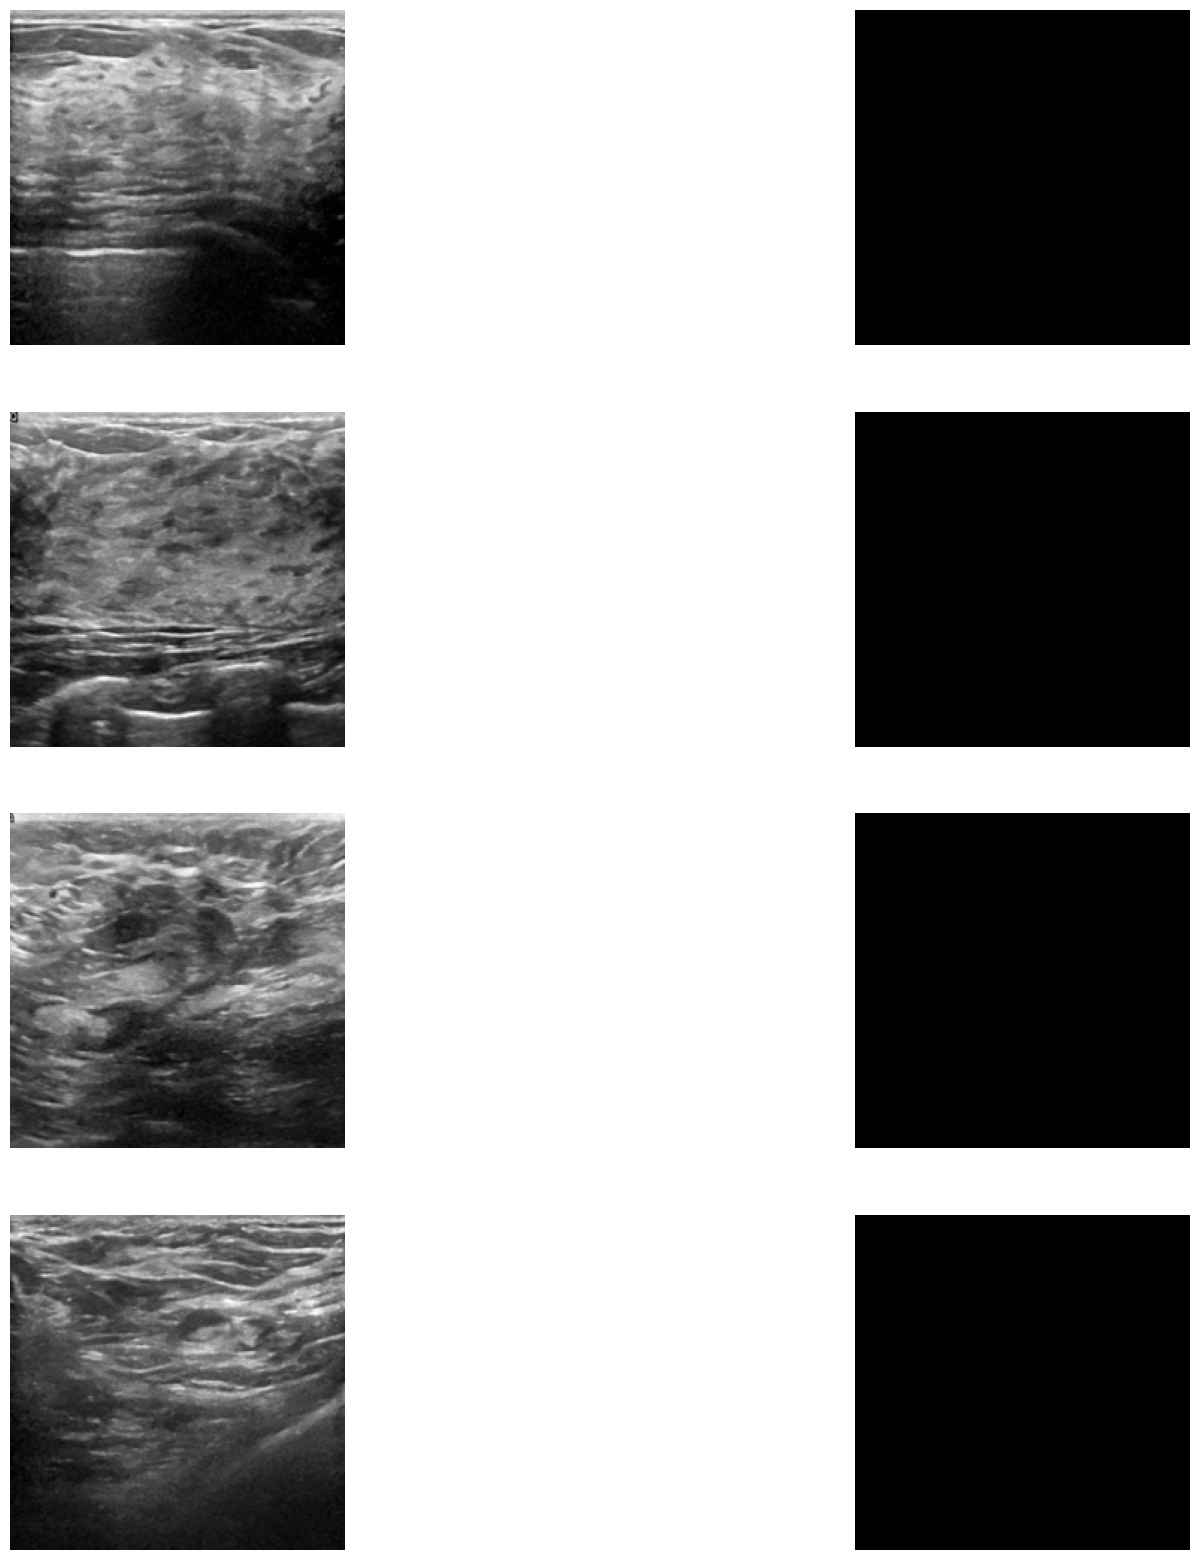

In [23]:
r, c = 4, 4  # Two rows, four columns (two for images and two for masks)
fig, ax = plt.subplots(r, c // 2, figsize=(20, 20))  # Only half the columns for images, half for masks

test = DataLoader(test_dataset, batch_size=8, shuffle=False)  # Batch size is half the number of rows
for data in test:
    x, y, label = data
    print(x.shape, y.shape)
    print(torch.unique(y))
    print(f"Class: {classes[label[0].to(torch.int64)]}")
    x,y = x.cpu(), y.cpu()
    # y = (y == -1).float()
    for i in range(r):
        img = x[i].numpy().transpose(1, 2, 0)
        mask = y[i].numpy().transpose(1, 2, 0) if y[i].ndim == 3 else y[i].numpy()  # Adjust mask format
        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(mask, cmap='gray')  # Display mask in grayscale
        ax[i, 1].axis('off')
    break

del test

# Model: Classification and Segmentation

In [24]:
# Hyperparameters
configs = {
    'batch_size': 8,
    'lr': 1e-4,
    'class': 1,
    'model': 'vgg19_bn',
    'epoch': 100,
    'encoder_weights' : 'imagenet',
    'weight_decay': 1e-3,
    'dropout': 0.5,
    'decoder_attention_type': 'scse'
    
    
}

import json
with open(f'{model_dir}/config.json', 'w') as file:
    json.dump(configs, file, indent=4)

In [25]:
aux_params = dict(
    pooling='avg',          # global pooling type, 'max' or 'avg'
    dropout=configs['dropout'],            # dropout ratio, must be a float in the range [0, 1] 
    classes=3,              # define the number of classes in the classification head
    activation='softmax',   # activation function'softmax'
)

In [26]:
model = smp.Unet(
    encoder_name=configs['model'],  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,              # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=1,                  # model output channels (number of classes in your segmentation task)
    aux_params=aux_params, 
    decoder_attention_type=configs['decoder_attention_type']# auxiliary parameters for the classification head
)
summary(model.to(DEVICE), (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

/home/ishu/.local/lib/python3.9/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [27]:
# Define the Dice loss for the segmentation task
segmentation_loss = smp.losses.DiceLoss(mode=smp.losses.constants.BINARY_MODE, from_logits=True)

# Define the loss function for the auxiliary classification task
classification_loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=configs['lr'], weight_decay=configs['weight_decay'])
scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.001)

### Metrics

In [28]:
from sklearn.metrics import f1_score
def calculate_metrics(outputs, masks):
    prob_mask = outputs.sigmoid()
    pred_mask = (prob_mask > 0.5).float()

    tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), masks.long(), mode="binary")
    return tp, fp, fn, tn

def calculate_dice_coefficient(tp, fp, fn):

    tp = np.mean(tp.cpu().numpy())
    fp = np.mean(fp.cpu().numpy())
    fn = np.mean(fn.cpu().numpy())
    return 2*(tp)/(2*tp + fn + fp)

def calculate_pixel_accuracy(tp, fp, fn, tn):
    tp = np.mean(tp.cpu().numpy())
    fp = np.mean(fp.cpu().numpy())
    fn = np.mean(fn.cpu().numpy())
    tn = np.mean(tn.cpu().numpy())

    return (tp + tn)/(tp + fn + fp + tn)

def classification_matrics(true_labels, pred_labels):
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    return f1


In [29]:
def compute_loss(model_outputs, true_masks, true_labels):
    # Calculate the loss for the segmentation output
    seg_loss = segmentation_loss(model_outputs[0], true_masks)
    # Calculate the loss for the classification output
    cls_loss = classification_loss(model_outputs[1], true_labels)
    # Combine the losses
    total_loss = seg_loss + cls_loss
    return total_loss, seg_loss, cls_loss


In [30]:
def train(model, dataloader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    num_correct = 0
    running_loss_total = 0.0
    running_loss_cls = 0.0
    running_loss_seg = 0.0

    train_tp, train_fp, train_fn, train_tn = [], [], [], []


    for i, (images, masks, true_label) in enumerate(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        true_label = true_label.to(DEVICE)
        # masks = (masks == -1).float()
        optimizer.zero_grad()
        outputs = model(images)
        output_masks, output_labels = outputs[0], outputs[1]
        # print(f"Outputs shape: {outputs.size()}, Masks shape: {masks.size()}")
        masks = masks.type_as(output_masks)
        # print(outputs.shape)
        total_loss, seg_loss, cls_loss = compute_loss(outputs, masks, true_label)
        total_loss.backward()
        optimizer.step()
        num_correct += int((torch.argmax(output_labels, dim=1)==true_label).sum())
        running_loss_total += total_loss.item()
        running_loss_cls += cls_loss.item()
        running_loss_seg += seg_loss.item()

        tp, fp, fn, tn = calculate_metrics(output_masks, masks)
        train_tp.append(tp)
        train_fp.append(fp)
        train_fn.append(fn)
        train_tn.append(tn)



    all_tp = torch.cat(train_tp)
    all_fp = torch.cat(train_fp)
    all_fn = torch.cat(train_fn)
    all_tn = torch.cat(train_tn)



    train_per_image_iou = smp.metrics.iou_score(all_tp, all_fp, all_fn, all_tn, reduction="micro-imagewise")
    train_dataset_iou = smp.metrics.iou_score(all_tp, all_fp, all_fn, all_tn, reduction="micro")


    batch_bar.set_postfix(
        total_loss="{:.04f}".format(running_loss_total/(i+1)),
        class_loss="{:.04f}".format(running_loss_cls/(i+1)),
        seg_loss="{:.04f}".format(running_loss_seg/(i+1)),
        lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
        train_per_image_iou='{:.04f}'.format(train_per_image_iou))
    batch_bar.update()

    del images, masks
    torch.cuda.empty_cache()
    acc = num_correct/(configs["batch_size"]*len(dataloader))*100
    running_loss_total /= len(dataloader)
    running_loss_cls /= len(dataloader)
    running_loss_seg /= len(dataloader)

    batch_bar.close()

    return running_loss_total, running_loss_cls, running_loss_seg , train_per_image_iou, train_dataset_iou, acc

In [31]:
def validate(model, dataloader):


    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")
    num_correct = 0
    running_loss_total = 0.0
    running_loss_cls = 0.0
    running_loss_seg = 0.0    
    val_tp, val_fp, val_fn, val_tn = [], [], [], []

    with torch.inference_mode():
        for i, (images, masks, true_label) in enumerate(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            true_label = true_label.to(DEVICE)
            # masks = (masks == -1).float()
            outputs = model(images)
            output_masks, output_labels = outputs[0], outputs[1]

            masks = masks.type_as(output_masks)
            total_loss, seg_loss, cls_loss = compute_loss(outputs, masks, true_label)
            running_loss_total += total_loss.item()
            running_loss_cls += cls_loss.item()
            running_loss_seg += seg_loss.item()
            num_correct += int((torch.argmax(output_labels, dim=1)==true_label).sum())
            # Calculate validation metrics

             # Convert outputs to binary predictions and calculate IoU using smp function
            tp, fp, fn, tn = calculate_metrics(output_masks, masks)
            val_tp.append(tp)
            val_fp.append(fp)
            val_fn.append(fn)
            val_tn.append(tn)

    all_tp = torch.cat(val_tp)
    all_fp = torch.cat(val_fp)
    all_fn = torch.cat(val_fn)
    all_tn = torch.cat(val_tn)



    val_per_image_iou = smp.metrics.iou_score(all_tp, all_fp, all_fn, all_tn, reduction="micro-imagewise")
    val_dataset_iou = smp.metrics.iou_score(all_tp, all_fp, all_fn, all_tn, reduction="micro")


    batch_bar.set_postfix(
        total_loss="{:.04f}".format(running_loss_total/(i+1)),
        class_loss="{:.04f}".format(running_loss_cls/(i+1)),
        seg_loss="{:.04f}".format(running_loss_seg/(i+1)),
        lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
        val_per_image_iou='{:.04f}'.format(val_per_image_iou))
    batch_bar.update()

    del images, masks
    torch.cuda.empty_cache()

    running_loss_total /= len(dataloader)
    running_loss_cls /= len(dataloader)
    running_loss_seg /= len(dataloader)
    acc = num_correct/(configs["batch_size"]*len(dataloader))*100
    batch_bar.close()

    return running_loss_total, running_loss_cls, running_loss_seg , val_per_image_iou, val_dataset_iou, acc

In [32]:
from datetime import datetime

def visualize_segmentation_result(image, true_mask, predicted_mask):
    # Convert tensors to numpy arrays
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    true_mask_np = true_mask.cpu().numpy().squeeze()
    predicted_mask_np = (predicted_mask > 0.5).float().cpu().numpy().squeeze()

    # Display the images and masks side by side
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_np, cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_np, cmap='gray')
    plt.title('Predicted Mask')

    
    # Get the current time
    current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    # Construct the file name using the current time
    file_name = f"{model_dir}/plot_{current_time}.png"
    plt.savefig(file_name)
    plt.show()

In [33]:
def test(model, dataloader):


    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Test")
    pred_labels = []
    true_labels = []
    test_tp, test_fp, test_fn, test_tn = [], [], [], []
    visualizations = []
    with torch.inference_mode():
        for i, (images, masks, true_label) in enumerate(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            true_label = true_label.to(DEVICE)
            # masks = (masks == -1).float()
            outputs = model(images)
            output_masks, output_labels = outputs[0], outputs[1]
            masks = masks.type_as(output_masks)
            
             # Convert outputs to binary predictions and calculate IoU using smp function
            tp, fp, fn, tn = calculate_metrics(output_masks, masks)
            test_tp.append(tp)
            test_fp.append(fp)
            test_fn.append(fn)
            test_tn.append(tn)
            visualizations.append((images[0], masks[0], output_masks[0]))
            output_labels = torch.argmax(output_labels, dim=1).detach().cpu().numpy().tolist()
            true_label = true_label.detach().cpu().numpy().tolist()
            pred_labels.extend(output_labels)
            true_labels.extend(true_label)


    all_tp = torch.cat(test_tp)
    all_fp = torch.cat(test_fp)
    all_fn = torch.cat(test_fn)
    all_tn = torch.cat(test_tn)
    
    dice_score = calculate_dice_coefficient(all_tp, all_fp, all_fn)
    pixel_score = calculate_pixel_accuracy(all_tp, all_fp, all_fn, all_tn)
    f1_score = classification_matrics(true_labels, pred_labels)
    


    test_per_image_iou = smp.metrics.iou_score(all_tp, all_fp, all_fn, all_tn, reduction="micro-imagewise")
    test_dataset_iou = smp.metrics.iou_score(all_tp, all_fp, all_fn, all_tn, reduction="micro")


    del images
    torch.cuda.empty_cache()


    batch_bar.close()

    return test_per_image_iou, test_dataset_iou, visualizations, dice_score, pixel_score, f1_score

# Train

In [34]:
patience = 10
best_val_loss = float('inf')
print('Training start')
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(0, configs['epoch']):

    print("\nEpoch: {}/{}".format(epoch+1, configs['epoch']))

    curr_lr = float(optimizer.param_groups[0]['lr'])


    train_total_loss, train_cls_loss, train_seg_loss, train_per_image_iou, train_dataset_iou, train_acc = train(model, train_loader, optimizer)
    train_loss_list.append(train_total_loss)
    train_iou_list.append(train_per_image_iou)
    train_acc_list.append(train_acc)
    # Print your metrics

    print("\nEpoch {}/{}: \n Train Total Loss {:.04f}\t Train acc {:.04f}\t Train Classification Loss {:.04f}\t  Train Segmentation Loss {:.04f}\t train_per_image_iou {:.04f}\t train_dataset_iou {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        configs['epoch'],
        train_total_loss,
        train_acc,
        train_cls_loss,
        train_seg_loss,
        train_per_image_iou,
        train_dataset_iou,
        curr_lr))


    val_total_loss, val_cls_loss, val_seg_loss, val_per_image_iou, val_dataset_iou, val_acc = validate(model, val_loader)
    print("Val Total loss {:.04f}\t Val Acc {:.04f}\t Val Classification loss {:.04f}\t Val Segmentation loss {:.04f}\t val_per_image_iou {:.04f}\t val_dataset_iou {:.04f}\t".format(val_total_loss, val_acc, val_cls_loss, val_seg_loss, val_per_image_iou, val_dataset_iou))
    val_loss_list.append(val_total_loss)
    val_iou_list.append(val_per_image_iou)
    val_acc_list.append(val_acc)
    # # Log metrics to Wandb
    # wandb.log({"train_loss":running_loss, 'perplexity': running_perplexity,
    #         'validation_dist': running_lev_dist, "learning_Rate": curr_lr})

    # Optional: Scheduler Step / Teacher Force Schedule Step
    scheduler.step(val_total_loss)



    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_total_loss < best_val_loss:
        best_val_loss = val_total_loss
        counter = 0
        #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
        print("Saving model")
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_total_loss': val_total_loss,
                    'epoch': epoch}, model_dir+'/best.pth')
    else:
        counter += 1
    if counter >= patience:
        print(f"early stop at epoch {epoch +1}")
        break

Training start

Epoch: 1/100



Epoch 1/100: 
 Train Total Loss 1.7154	 Train acc 62.6838	 Train Classification Loss 0.9450	  Train Segmentation Loss 0.7703	 train_per_image_iou 0.1806	 train_dataset_iou 0.2173	 Learning Rate 0.0001


Val Total loss 1.6361	 Val Acc 47.3214	 Val Classification loss 1.0217	 Val Segmentation loss 0.6144	 val_per_image_iou 0.1796	 val_dataset_iou 0.1999	
Saving model

Epoch: 2/100



Epoch 2/100: 
 Train Total Loss 1.3398	 Train acc 85.8456	 Train Classification Loss 0.7422	  Train Segmentation Loss 0.5976	 train_per_image_iou 0.3426	 train_dataset_iou 0.4222	 Learning Rate 0.0001


Val Total loss 1.4679	 Val Acc 56.2500	 Val Classification loss 0.9542	 Val Segmentation loss 0.5137	 val_per_image_iou 0.3390	 val_dataset_iou 0.4093	
Saving model

Epoch: 3/100



Epoch 3/100: 
 Train Total Loss 1.1232	 Train acc 93.3824	 Train Classification Loss 0.6577	  Train Segmentation Loss 0.4655	 train_per_image_iou 0.4934	 train_dataset_iou 0.5434	 Learning Rate 0.0001


Val Total loss 1.4892	 Val Acc 50.0000	 Val Classification loss 0.9967	 Val Segmentation loss 0.4925	 val_per_image_iou 0.4669	 val_dataset_iou 0.3803	

Epoch: 4/100



Epoch 4/100: 
 Train Total Loss 0.9943	 Train acc 96.3235	 Train Classification Loss 0.6194	  Train Segmentation Loss 0.3749	 train_per_image_iou 0.6524	 train_dataset_iou 0.6102	 Learning Rate 0.0001


Val Total loss 1.4031	 Val Acc 55.3571	 Val Classification loss 0.9433	 Val Segmentation loss 0.4598	 val_per_image_iou 0.4958	 val_dataset_iou 0.3827	
Saving model

Epoch: 5/100



Epoch 5/100: 
 Train Total Loss 0.9089	 Train acc 97.0588	 Train Classification Loss 0.6019	  Train Segmentation Loss 0.3071	 train_per_image_iou 0.6819	 train_dataset_iou 0.6451	 Learning Rate 0.0001


Val Total loss 1.3948	 Val Acc 49.1071	 Val Classification loss 0.9784	 Val Segmentation loss 0.4164	 val_per_image_iou 0.4822	 val_dataset_iou 0.4115	
Saving model

Epoch: 6/100



Epoch 6/100: 
 Train Total Loss 0.8558	 Train acc 97.4265	 Train Classification Loss 0.6028	  Train Segmentation Loss 0.2530	 train_per_image_iou 0.7282	 train_dataset_iou 0.7014	 Learning Rate 0.0001


Val Total loss 1.2682	 Val Acc 81.2500	 Val Classification loss 0.8114	 Val Segmentation loss 0.4568	 val_per_image_iou 0.5544	 val_dataset_iou 0.3533	
Saving model

Epoch: 7/100



Epoch 7/100: 
 Train Total Loss 0.8157	 Train acc 97.7941	 Train Classification Loss 0.5911	  Train Segmentation Loss 0.2246	 train_per_image_iou 0.7429	 train_dataset_iou 0.7183	 Learning Rate 0.0001


Val Total loss 1.2655	 Val Acc 58.9286	 Val Classification loss 0.8928	 Val Segmentation loss 0.3728	 val_per_image_iou 0.5747	 val_dataset_iou 0.4731	
Saving model

Epoch: 8/100



Epoch 8/100: 
 Train Total Loss 0.7958	 Train acc 97.6103	 Train Classification Loss 0.5937	  Train Segmentation Loss 0.2021	 train_per_image_iou 0.7458	 train_dataset_iou 0.7183	 Learning Rate 0.0001


Val Total loss 1.3085	 Val Acc 66.9643	 Val Classification loss 0.8637	 Val Segmentation loss 0.4448	 val_per_image_iou 0.5489	 val_dataset_iou 0.3615	

Epoch: 9/100



Epoch 9/100: 
 Train Total Loss 0.7701	 Train acc 97.2426	 Train Classification Loss 0.5878	  Train Segmentation Loss 0.1823	 train_per_image_iou 0.7654	 train_dataset_iou 0.7519	 Learning Rate 0.0001


Val Total loss 1.3330	 Val Acc 56.2500	 Val Classification loss 0.9319	 Val Segmentation loss 0.4011	 val_per_image_iou 0.5677	 val_dataset_iou 0.4395	

Epoch: 10/100



Epoch 10/100: 
 Train Total Loss 0.7696	 Train acc 97.9779	 Train Classification Loss 0.5887	  Train Segmentation Loss 0.1809	 train_per_image_iou 0.7655	 train_dataset_iou 0.7401	 Learning Rate 0.0001


Val Total loss 1.3792	 Val Acc 57.1429	 Val Classification loss 0.9191	 Val Segmentation loss 0.4601	 val_per_image_iou 0.4767	 val_dataset_iou 0.3248	

Epoch: 11/100



Epoch 11/100: 
 Train Total Loss 0.7474	 Train acc 98.3456	 Train Classification Loss 0.5833	  Train Segmentation Loss 0.1642	 train_per_image_iou 0.7842	 train_dataset_iou 0.7629	 Learning Rate 0.0001


Val Total loss 1.3606	 Val Acc 58.9286	 Val Classification loss 0.9276	 Val Segmentation loss 0.4331	 val_per_image_iou 0.5582	 val_dataset_iou 0.3851	

Epoch: 12/100



Epoch 12/100: 
 Train Total Loss 0.7112	 Train acc 98.5294	 Train Classification Loss 0.5763	  Train Segmentation Loss 0.1348	 train_per_image_iou 0.8146	 train_dataset_iou 0.8078	 Learning Rate 0.0001


Val Total loss 1.3445	 Val Acc 64.2857	 Val Classification loss 0.8909	 Val Segmentation loss 0.4535	 val_per_image_iou 0.5371	 val_dataset_iou 0.3469	

Epoch: 13/100


Train:   0%|          | 0/68 [00:00<?, ?it/s]

# Load Checkpoint

In [ ]:
checkpoint = torch.load(f'{model_dir}/best.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Test

In [ ]:
test_per_image_iou, test_dataset_iou, test_visualizations, dice_score, pixel_score, f1_score_test = test(model, test_loader)
# print(f"Average Dice Coefficient {dice_score}, Average Pixel Accuracy {pixel_score}")
print(test_per_image_iou,test_dataset_iou)
print(f"Average Dice Score is {dice_score}")
print(f"Average Pixel Score is {pixel_score}")
print(f"Average F1 Score is {f1_score_test}")

for vis in test_visualizations:
    visualize_segmentation_result(*vis)

In [ ]:
for i in range(len(train_iou_list)):
  train_iou_list[i] = train_iou_list[i].cpu()
  val_iou_list[i] = val_iou_list[i].cpu()


# Plot

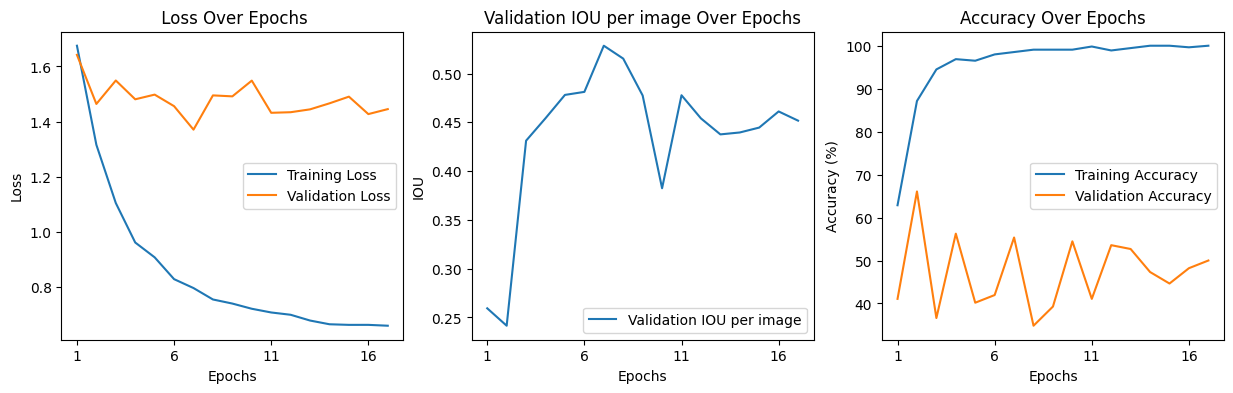

In [ ]:
# Plotting
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xticks(range(0, len(train_loss_list), 5), labels=range(1, len(train_loss_list) +1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' Loss Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
# plt.plot(train_iou_list, label='Training IOU per image')
plt.plot(val_iou_list, label='Validation IOU per image')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.xticks(range(0, len(train_loss_list), 5), labels=range(1, len(train_loss_list) +1, 5))
plt.title('Validation IOU per image Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
# plt.plot(train_iou_list, label='Training IOU per image')
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xticks(range(0, len(train_acc_list), 5), labels=range(1, len(val_acc_list) +1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.savefig(f'{model_dir}/curve.png')

plt.show()


# Compare Different Models

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
# File paths for the CSV files
file_paths = ['resnet50_attend.csv', 'resnet50.csv']

# List to store dataframes
dataframes = []

import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
file1 = 'resnet50_attend.csv'
file2 = 'resnet50.csv'

data1 = pd.read_csv(file1)
data2 = pd.read_csv(file2)

# Extract the first and second columns
train_loss_attend = data1.iloc[:, 0]
train_iou_attend = data1.iloc[:, 1]
train_iou_attend = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in train_iou_attend]
val_loss_attend = data1.iloc[:, 2]
val_iou_attend = data1.iloc[:, 3]
val_iou_attend = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in val_iou_attend]

train_loss= data2.iloc[:, 0]
train_iou = data2.iloc[:, 1]
train_iou = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in train_iou]

val_loss = data2.iloc[:, 2]
val_iou = data2.iloc[:, 3]
val_iou = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in val_iou]

# Plotting
plt.figure(figsize=(12, 6))

# Plot for the first column
plt.subplot(1, 2, 1)
plt.plot(val_loss_attend, label='ResNet50 + Attend (Val)')
plt.plot(val_loss, label='ResNet50 (Val)')
plt.plot(train_loss_attend, label='ResNet50 + Attend (Train)')
plt.plot(train_loss, label='ResNet50 (Train)')
plt.title('Loss Over Epochs')
plt.xticks(range(0, len(val_loss_attend), 5), labels=range(1, len(val_loss_attend) +1, 5))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for the second column
plt.subplot(1, 2, 2)
plt.plot(val_iou_attend, label='ResNet50 + Attend (Val)')
plt.plot(val_iou, label='ResNet50 (Val)')
plt.plot(train_iou_attend, label='ResNet50 + Attend (Train)')
plt.plot(train_iou, label='ResNet50 (Train)')
plt.title('IoU Over Epochs')
plt.xticks(range(0, len(val_loss_attend), 5), labels=range(1, len(val_loss_attend) +1, 5))
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.savefig('Attention_compare.png')
plt.show()



In [ ]:
file_vgg16 = 'vgg16.csv'
file2_vgg19 = 'vgg19.csv'
file3_res = 'resnet50_attend.csv'
file4_dpn = 'dpn-numbers.csv'


vgg16 = pd.read_csv(file_vgg16)
vgg19 = pd.read_csv(file2_vgg19)
resnet50 = pd.read_csv(file3_res)
dnp = pd.read_csv(file4_dpn)


# Extract the first and second columns
train_loss_vgg16 = vgg16.iloc[:, 0]
train_iou_vgg16 = vgg16.iloc[:, 1]
train_iou_vgg16 = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in train_iou_vgg16]
val_loss_vgg16 = vgg16.iloc[:, 2]
val_iou_vgg16 = vgg16.iloc[:, 3]
val_iou_vgg16 = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in val_iou_vgg16]

train_loss_vgg19 = vgg19.iloc[:, 0]
train_iou_vgg19 = vgg19.iloc[:, 1]
train_iou_vgg19 = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in train_iou_vgg19]
val_loss_vgg19 = vgg19.iloc[:, 2]
val_iou_vgg19 = vgg19.iloc[:, 3]
val_iou_vgg19 = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in val_iou_vgg19]

train_loss_resnet50= resnet50.iloc[:, 0]
train_iou_resnet50 = resnet50.iloc[:, 1]
train_iou_resnet50 = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in train_iou_resnet50]

val_loss_resnet50 = resnet50.iloc[:, 2]
val_iou_resnet50 = resnet50.iloc[:, 3]
val_iou_resnet50 = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in val_iou_resnet50]

train_loss_dnp = dnp.iloc[:, 0]
train_iou_dnp = dnp.iloc[:, 1]
train_iou_dnp = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in train_iou_dnp]

val_loss_dnp = dnp.iloc[:, 2]
val_iou_dnp = dnp.iloc[:, 3]
val_iou_dnp = [float(re.search(r"\((.*?)\)", iou_str).group(1)) for iou_str in val_iou_dnp]


In [ ]:
plt.figure(figsize=(12, 6))

# Plot for the first column
plt.subplot(2, 2, 1)
plt.plot(train_loss_vgg16, label='VGG16')
plt.plot(train_loss_vgg19, label='VGG19')
plt.plot(train_loss_resnet50, label='ResNet50')
plt.plot(train_loss_dnp, label='DPN')
plt.title('Train Loss Over Epochs')
plt.xticks(range(0, len(train_loss_dnp), 5), labels=range(1, len(train_loss_dnp) +1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(val_loss_vgg16, label='VGG16')
plt.plot(val_loss_vgg19, label='VGG19')
plt.plot(val_loss_resnet50, label='ResNet50')
plt.plot(val_loss_dnp, label='DPN')
plt.title('Validation Loss Over Epochs')
plt.xticks(range(0, len(train_loss_dnp), 5), labels=range(1, len(train_loss_dnp) +1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()




# Plot for the second column
plt.subplot(2, 2, 3)
plt.plot(train_iou_vgg16, label='VGG16')
plt.plot(train_iou_vgg19, label='VGG19')
plt.plot(train_iou_resnet50, label='ResNet50')
plt.plot(train_iou_dnp, label='DPN')
plt.title('Train IoU Over Epochs')
plt.xticks(range(0, len(train_loss_dnp), 5), labels=range(1, len(train_loss_dnp) +1, 5))
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()




plt.subplot(2, 2, 4)
plt.plot(val_iou_vgg16, label='VGG16')
plt.plot(val_iou_vgg19, label='VGG19')
plt.plot(val_iou_resnet50, label='ResNet50')
plt.plot(val_iou_dnp, label='DPN')
plt.title('Validation IoU Over Epochs')
plt.xticks(range(0, len(train_loss_dnp), 5), labels=range(1, len(train_loss_dnp) +1, 5))
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.savefig('Model_compare.png')
plt.show()